# In this notebook
I look at the relationship between the station intensity and income.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# For data manipulation
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt

# For statistics
import statsmodels.api as sm
import pymc as pm
import arviz as az

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [2]:
# This code loads the census tract shapefile for Durham County
count_data = gpd.read_file('../preprocessed_data/durham_july_2021/durham_july_2021_census_tract.shp')

# Remove the row with no population
count_data = count_data[count_data['population'] != 0]
print(len(count_data))
no_income_mask = count_data[count_data['income'].isna()]

67


In [3]:
# Let's get the variables we care about from the dataframe
log_income = np.log(count_data['income'].values)
log_income_std = (log_income - np.mean(log_income)) / np.std(log_income)

area = count_data['area'].values / 1e6
population = count_data['population'].values / 1e3
num_stations = count_data['num_statio'].values

# Let's look at station density by income

In [9]:
# Define the model
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100)
    log_intensity = alpha + beta * log_income_std
    intensity = pm.math.exp(log_intensity)

    rates = intensity * population

    counts = pm.Poisson('counts', mu=rates, observed=num_stations)

# Run MCMC
with model:
    trace = pm.sample(1000, tune=1000, chains=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


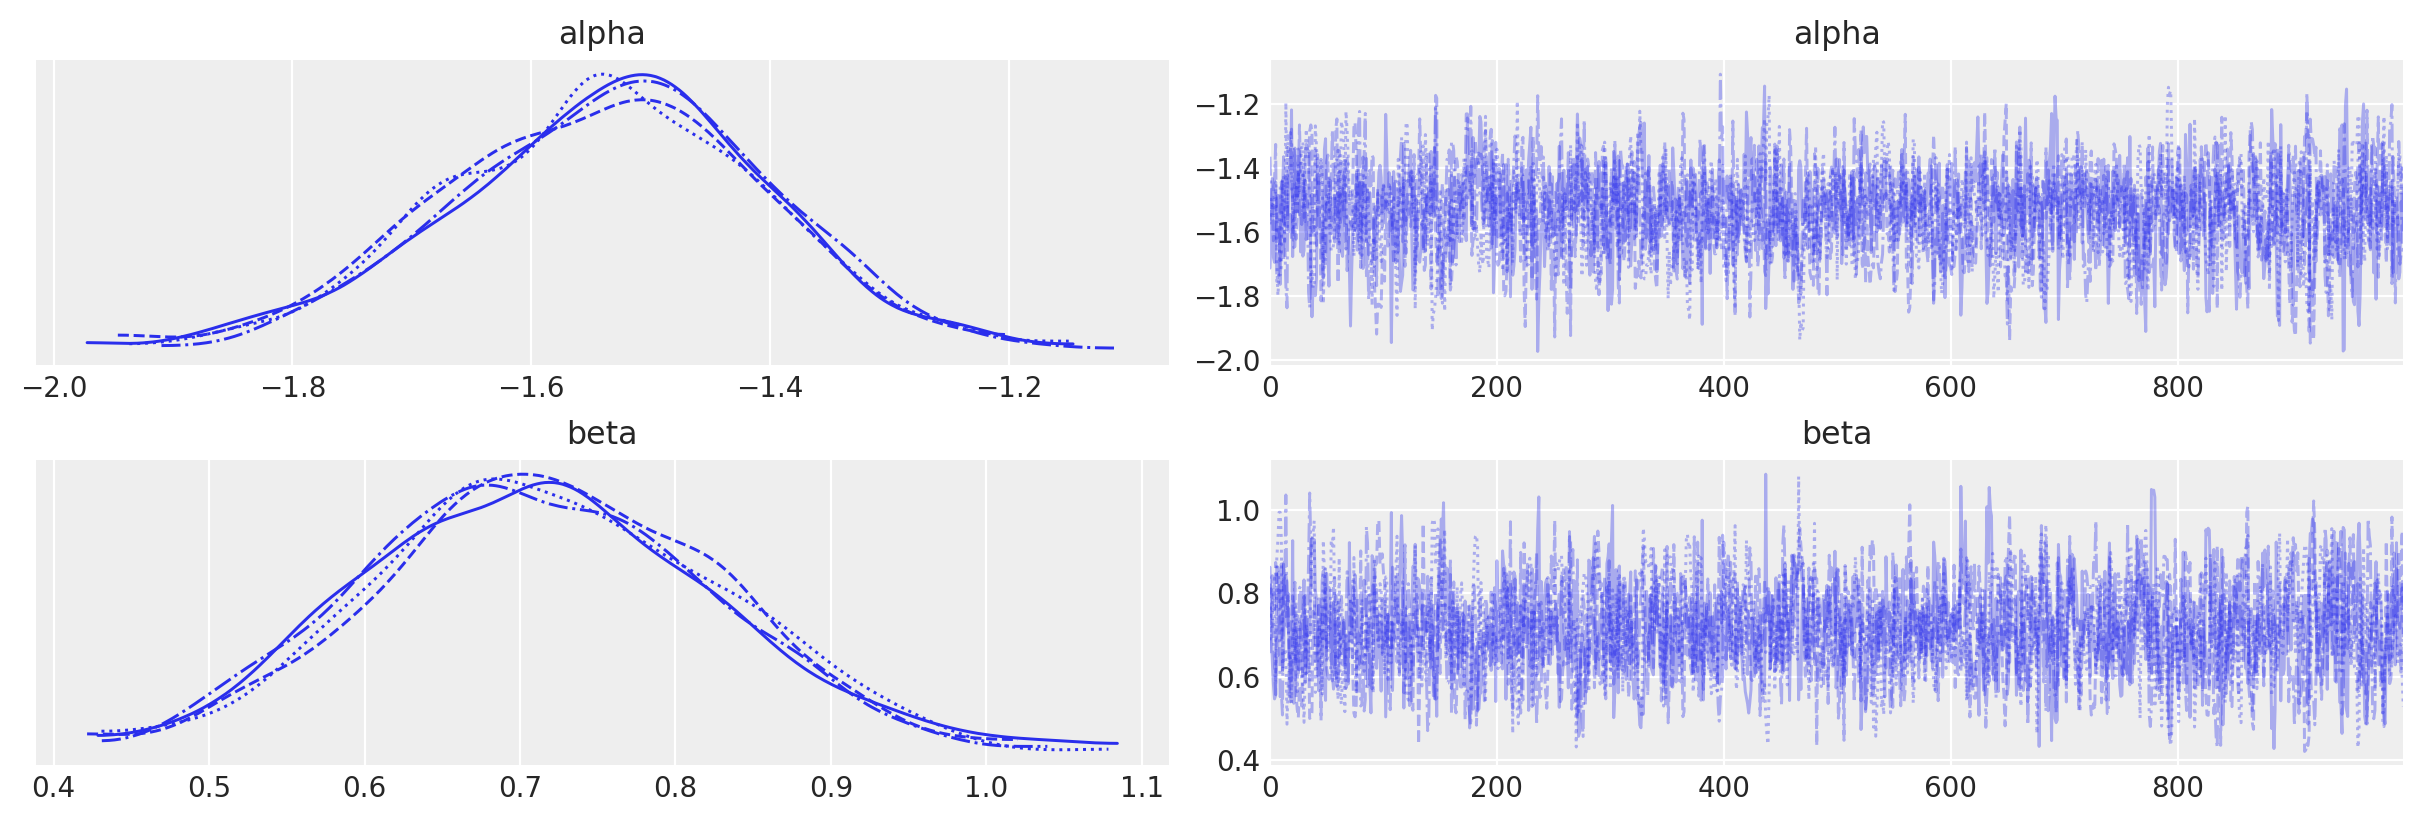

In [6]:
az.plot_trace(trace)
plt.show()

In [7]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.537,0.134,-1.804,-1.300,0.003,0.002,1576.0,1967.0,1.0
beta,0.715,0.109,0.511,0.917,0.003,0.002,1543.0,2073.0,1.0


Now, lets visualize this result

Text(0, 0.5, 'Intensity (stations / 1000 people)')

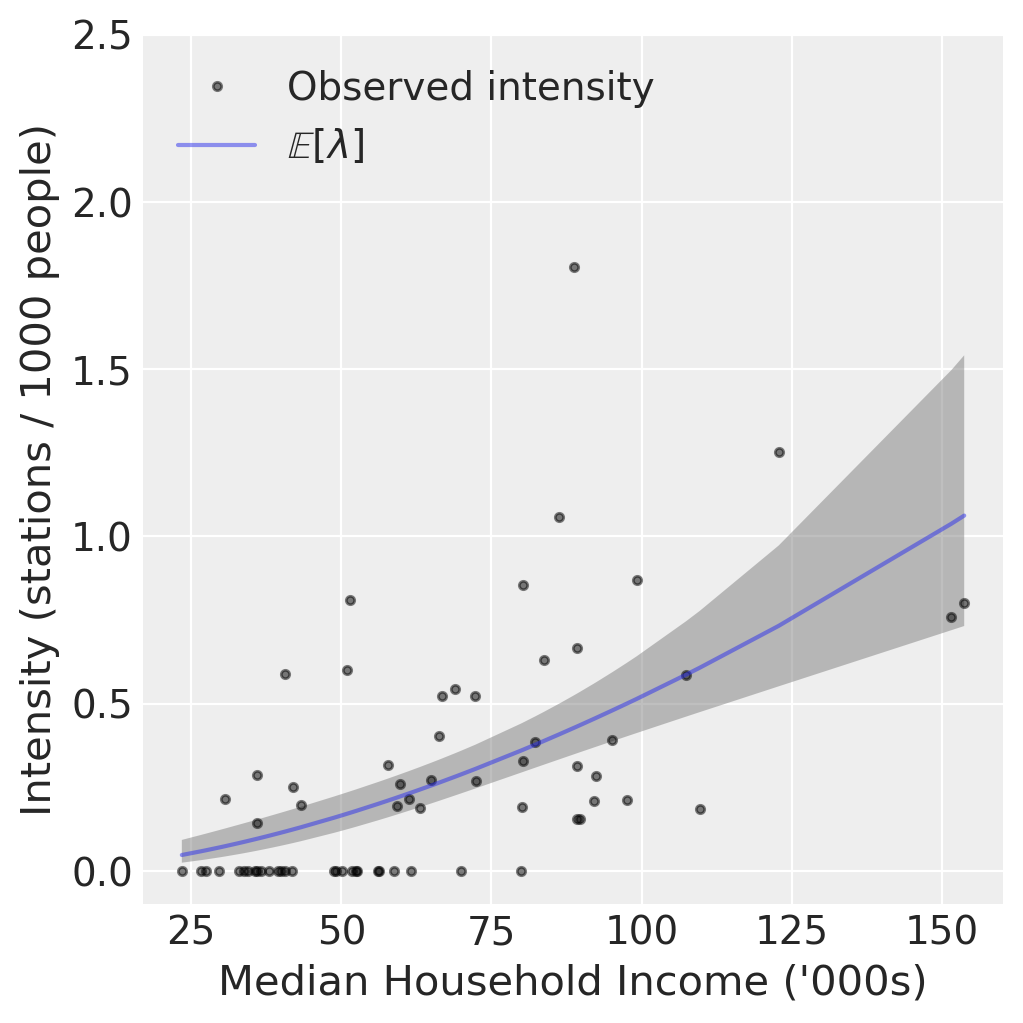

In [8]:
fig = plt.figure(figsize=(5, 5))

order = np.argsort(log_income_std)
log_income_sorted = log_income_std[order]
income_sorted = np.array(count_data['income'])[order]

plt.plot(income_sorted/1000, num_stations[order] / population[order], 'k.', alpha=0.5, label='Observed intensity')

# plot the posterior predictive sample
alpha = trace.posterior['alpha'].values.flatten()
beta = trace.posterior['beta'].values.flatten()

# Calculate the mean and standard deviation
mean_val = trace.posterior['alpha'].values.mean() + trace.posterior['beta'].values.mean() * log_income_std
# std_val = trace.posterior['alpha'].values + trace.posterior['beta'].values * log_income_std

res= trace.posterior['alpha'].values.flatten()[:, np.newaxis] + trace.posterior['beta'].values.flatten()[:, np.newaxis] * log_income_std
std_val = np.std(res, axis=0)

plt.plot(income_sorted/1000, np.exp(mean_val[order]), alpha=0.5, label='$\mathbb{E}[\lambda]$')
plt.fill_between(income_sorted/1000, np.exp(mean_val[order] - 2*std_val[order]), np.exp(mean_val[order] + 2*std_val[order]),color='grey', edgecolor=None, alpha=0.5)

plt.legend(loc='upper left')
plt.ylim(-0.1, 2.5)

plt.xlabel("Median Household Income ('000s)")
plt.ylabel("Intensity (stations / 1000 people)")

# Save figure
# plt.savefig('../results/figures/stations_per_population.pdf', dpi=300)

Now, let's fit a GLM and look at the significance of this model (this is the same thing as the model fit above, just using the Frequentist approach).

In [25]:
# add a constant
X = np.column_stack([ np.ones(len(log_income_std)), log_income_std])
# offset by the population
poisson_model = sm.GLM(num_stations, X, family=sm.families.Poisson(), offset=np.log(population)).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   67
Model:                            GLM   Df Residuals:                       65
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -92.369
Date:                Fri, 31 May 2024   Deviance:                       82.135
Time:                        15:33:25   Pearson chi2:                     85.9
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4816
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5230      0.134    -11.329      0.0